In [1]:
import dgl
import pandas as pd
import numpy as np
import torch 
import os
import sys
sys.path.append('./../..')
sys.path.append('./..')
from tqdm import tqdm
import argparse
import pandas as pd
import numpy as np
import sys
sys.path.append('./..')
sys.path.append('./../..')
from pathlib import Path
import os
from common_utils import utils
from joblib import Parallel,delayed
import multiprocessing as mp
import pickle 
from torch import LongTensor as LT
from torch import FloatTensor as FT
from torch.nn import functional as F
import dgl.function as fn
from torch import nn
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine
from  sklearn.manifold import TSNE


# ==============================================
# GLOBALS 
# ==============================================

DIR = 'us_import1'
# Use training data for graph creation
DATA_LOC = './../generated_data_v1/{}'.format(DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(os.path.join(DATA_LOC,'domain_dims.pkl'),'rb') as fh:
    domain_dims = pickle.load(fh) 
    
# ----------------------------
# First create a bipartite graph using training data  
# 2 entity types : Consignee and Shipper
# Prefixes : 'Consignee' 'Shipper'
# ----------------------------
SAVE_DIR = 'saved_model_data'
attr_consignee_prefix = 'ConsigneePanjivaID'
attr_shipper_prefix = 'ShipperPanjivaID'
bipartite_domains = sorted([attr_consignee_prefix, attr_shipper_prefix])

Using backend: pytorch
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def get_data_df():
    global attr_consignee_prefix
    global bipartite_domains
    global attr_shipper_prefix
    global DATA_LOC
 
    global DIR
    
    with open(os.path.join(DATA_LOC,'domain_dims.pkl'),'rb') as fh:
        domain_dims = pickle.load(fh)
        
    # This data does not have serial ID but domain specific ID
    data_df = pd.read_csv(os.path.join(DATA_LOC, 'train_data.csv'),index_col=None, low_memory=False)
    data_df = data_df.drop_duplicates(subset=list(domain_dims.keys()))
    # group by
    g_df = data_df.groupby([attr_consignee_prefix, attr_shipper_prefix]).size().reset_index(name='weight')
    
    # -----------------------------
    # Create synthetic mappiing 
    # -----------------------------
  
    synID = 0
    cur = 0
    col_syn_id = []
    col_entity_id = []
    col_domain_names = []
    # ------------------
    for d in sorted(bipartite_domains):
        s = domain_dims[d]
        col_entity_id.extend(list(range(s)))
        col_domain_names.extend([d for _ in range(s)])
        tmp = np.arange(s) + cur
        tmp = tmp.tolist()
        col_syn_id.extend(tmp)
        cur += s

    data = {'domain': col_domain_names, 'entity_id': col_entity_id, 'syn_id': col_syn_id}
    synID_mapping_df = pd.DataFrame(data)
    
    # -------------------
    # Replace entity_id with synthetic id 
    # -------------------
    mapping_dict = {}
    for domain in set(synID_mapping_df['domain']):
        tmp =  synID_mapping_df.loc[(synID_mapping_df['domain'] == domain)]
        syn_id = tmp['syn_id'].values.tolist()
        entity_id = tmp['entity_id'].values.tolist()
        mapping_dict[domain] = {k:v for k,v in zip(entity_id,syn_id)}
        
    def convert_aux(val, domain):
        return mapping_dict[domain][val]

    for domain in tqdm(bipartite_domains):
        g_df[domain] = g_df[domain].parallel_apply(convert_aux, args=(domain,))
        
        
    return g_df, synID_mapping_df, data_df


In [3]:
# ------------------------------

# ------------------------------
'''
Core GNN 
'''
class GNN_1(torch.nn.Module):
    def __init__(
        self,
        inp_dim,
        out_dim,
        input_feature_label='mp2v', 
        aggregator_type='mean',
        bias=True,
        norm=True,
        activation=None
    ):
        super(GNN_1, self).__init__()
        self.out_dim = out_dim
        self.inp_dim = inp_dim
        self.aggregator_type = aggregator_type
        self.norm = norm
        self.activation = activation
        # ------
        # Assuming a 2 layer GNN
        # ------
        self.num_layers = 2 
        self.input_feature_label= input_feature_label
        self.FC_w = nn.Linear(
            self.inp_dim * 3, 
            self.out_dim, 
            bias=bias
        )
        
        self.reset_parameters()
        self.aggregator_type = aggregator_type
        return
    
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_uniform_(
            self.FC_w.weight, 
            gain=gain
        )
        return
    
    
    def forward(self, graph_obj):   
        
        for layer in range( self.num_layers ):
            # --------------------------------------
            # If first layer initialize features with input features, then perform computation
            # --------------------------------------
            if layer == 0 :
                # For the 1st layer initilize features with input feature
                graph_obj.ndata['features'] = graph_obj.ndata[self.input_feature_label]
                graph_obj.update_all(
                    fn.copy_u('features', 'm'),
                    fn.mean('m', 'h')
                ) 
            else:
                # ------------------------------
                # Update along the given edge
                # ------------------------------
                graph_obj.update_all(
                    fn.copy_u('features', 'm'),
                    fn.mean('m', 'h')
                )
                concat_ftrs = torch.cat([
                    graph_obj.ndata['features'],
                    graph_obj.ndata['h'],
                    graph_obj.ndata[self.input_feature_label]
                    ], 
                    dim=1
                )
                
                ftrs = self.FC_w(concat_ftrs)
                ftrs = F.tanh(ftrs)
                if self.norm:
                    ftrs = ftrs/torch.norm(ftrs, p=2)
                graph_obj.ndata['features'] = ftrs 
        return

In [4]:
# --------------------------------------
# Triplet loss for training the GNN
# --------------------------------------
def triplet_loss( xt, xp, xn):
    m = 0.25
    v1 = 1 - F.cosine_similarity(xt, xp, dim=1)
    v2 = 1 - F.cosine_similarity(xt, xn, dim=1)
    d =  v1 - v2 + m
    loss = torch.max(d, torch.zeros_like(d))
    return torch.mean(loss, dim=0, keepdim=False)

def generate_pos_neg_neighbors(
    graph_obj
):
    # The source nodes 
    nodes = graph_obj.nodes().cpu().data.numpy()
    edges = graph_obj.edges()
    node_src = edges[0].cpu().data.numpy()
    node_dest = edges[1].cpu().data.numpy()
    
    pos_nbrs = { _ : [] for _ in nodes }
    neg_nbrs = { _ : [] for _ in nodes }
    
    for i,j  in zip(node_src, node_dest):
        pos_nbrs[i].append(j)
    
    # Stor the list of neighbors as values in the dictionary
    neg_nbr_dict = {}
    pos_nbr_dict = {}

    for node in nodes:
        pos_nbrs[node] = set(pos_nbrs[node])
        neg_nbrs[node] = list(set(nodes).difference(pos_nbrs[node]))
        neg_nbr_dict[node] = list(neg_nbrs[node])
        pos_nbr_dict[node] = list(pos_nbrs[node])
        
    return pos_nbr_dict,neg_nbr_dict

In [5]:
def generate_training_triplets(pos_nbr_dict,neg_nbr_dict):
    nodes = list(pos_nbr_dict.keys())
    pos_pairs = []
    neg_pairs = []
    triplets = []
    
    def aux(n):
        return (n, 
                np.random.choice(pos_nbr_dict[n],size=1)[0], 
                np.random.choice(neg_nbr_dict[n],size=1)[0]
               )
    
    for n in nodes:
        t = aux(n)
        triplets.append(t)
    triplets = np.array(triplets)
    triplets = triplets[triplets[:,0].argsort()]
    return triplets

In [6]:
def train_model(
    graph_obj, 
    gnn_obj,
    pos_nbr_dict,
    neg_nbr_dict,
    num_epochs = 10
):
    print(graph_obj)
    # Optimizer
    opt = torch.optim.Adam(
        list(gnn_obj.parameters())
    )
    
    pbar = tqdm(range(num_epochs))
    for e in pbar :
        opt.zero_grad()
        triplets = generate_training_triplets(pos_nbr_dict,neg_nbr_dict)
        
        # Forward
        gnn_obj(graph_obj)
        idx_t = LT(triplets[:,0])
        emb_t = graph_obj.ndata['features'][idx_t,:] 
       
        idx_p = LT(triplets[:,1])
        idx_n = LT(triplets[:,2])
        emb_p = graph_obj.ndata['features'][idx_p,:] 
        emb_n = graph_obj.ndata['features'][idx_n,:] 
        loss_val = triplet_loss(emb_t, emb_p, emb_n)
        loss_val.backward()
        opt.step()
        pbar.set_postfix({'Loss': '{:4f}'.format(np.mean(loss_val.cpu().data.numpy()))})
    return 

In [10]:
def main():
    
    global device 
    global attr_consignee_prefix
    global bipartite_domains
    global attr_shipper_prefix
    global SAVE_DIR
    global DIR
    SAVE_LOC = os.path.join(SAVE_DIR,DIR)
    path_obj = Path(SAVE_LOC)
    path_obj.mkdir(exist_ok=True,parents=True)
    
    print('Device ', device)
    g_df, synID_mapping_df, data_df = get_data_df()
    # ----------------------------------
    # Read In metapath2vec features  
    # Those are stored as numpy arrays
    # ---------------------------------.
    mp2v_features = {}
    MP2V_features_LOC = os.path.join('./../createGraph_trade/saved_model_data', DIR)
    for attr in bipartite_domains:
        file = os.path.join(MP2V_features_LOC, 'mp2v_{}.npy'.format(attr))
        mp2v_features[attr] = np.load(file)

    '''
    To feed data into DGL graph 
    Create tensor of features
    '''
    input_emb_size = list(mp2v_features.values())[0].shape[1]
    num_entities = len(synID_mapping_df)
    input_features = np.zeros([num_entities, input_emb_size])

    for d in bipartite_domains:
        tmp = synID_mapping_df.loc[synID_mapping_df['domain']==d]
        _syn_id = tmp['syn_id'].values.tolist()
        _entity_id = tmp['entity_id'].values.tolist()
        input_features[_syn_id] = mp2v_features[d][_entity_id]


    src = g_df[attr_consignee_prefix].values.tolist()
    dst =  g_df[attr_shipper_prefix].values.tolist()
    nodes_src = src + dst
    nodes_dst = dst + src
    weights = g_df['weight'].values.tolist() +  g_df['weight'].values.tolist()
    # DGL is not undirected by default 
    graph_obj = dgl.graph((nodes_src,nodes_dst))
    graph_obj.edata['weight'] = FT(weights)
    graph_obj.ndata['mp2v'] = FT(input_features) 
    graph_obj = graph_obj.to(device)
        
    print(' Graph object >> ', graph_obj)
    gnn_obj = GNN_1(
        inp_dim = input_features.shape[1],
        out_dim = 32
    )
    
    gnn_obj = gnn_obj.to(device)
    pos_nbr_dict,neg_nbr_dict = generate_pos_neg_neighbors(graph_obj)

    train_model(
        graph_obj, 
        gnn_obj,
        pos_nbr_dict,
        neg_nbr_dict,
        num_epochs = 75 
    )
    
    # Extract node features 
    gnn_features = graph_obj.ndata['features'].cpu().data.numpy()
    
    # -------------------------------
    # Place feature in numpy arrays with entity_ID
    
    for d in bipartite_domains:
        tmp = synID_mapping_df.loc[synID_mapping_df['domain']==d]
        _syn_id = tmp['syn_id'].values.tolist()
        _entity_id = tmp['entity_id'].values.tolist()
        x =  np.zeros([len(tmp), gnn_features.shape[1]])
        x[_entity_id] = gnn_features[_syn_id]
        
        # Save the data 
        file_name = '{}_gnn_{}.npy'.format(d, gnn_features.shape[1])
        file_path = os.path.join(SAVE_LOC, file_name)
        np.save( file_path, x)
        
    return gnn_features
        
    

In [11]:
main()

  0%|          | 0/2 [00:00<?, ?it/s]

Device  cuda


100%|██████████| 2/2 [00:13<00:00,  6.50s/it]


 Graph object >>  Graph(num_nodes=10012, num_edges=36394,
      ndata_schemes={'mp2v': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})


  0%|          | 0/75 [00:00<?, ?it/s]

Graph(num_nodes=10012, num_edges=36394,
      ndata_schemes={'mp2v': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})


100%|██████████| 75/75 [10:02<00:00,  8.04s/it, Loss=0.026282]


array([[-0.00204493,  0.00119237,  0.00204646, ..., -0.00204628,
        -0.00204469,  0.00204641],
       [-0.00203726,  0.00067196,  0.00166063, ..., -0.002046  ,
         0.00203491,  0.0020437 ],
       [ 0.00100925, -0.00202088,  0.00204381, ...,  0.00198483,
        -0.00192039, -0.00124889],
       ...,
       [-0.00181596, -0.00199988,  0.00202175, ...,  0.00196974,
        -0.00203484,  0.00200284],
       [-0.00096095,  0.00192463, -0.00173738, ..., -0.00073141,
        -0.00165664, -0.0017211 ],
       [ 0.0007548 , -0.00203694, -0.00204338, ...,  0.00203986,
        -0.00187201, -0.00170101]], dtype=float32)

In [44]:
data = graph_obj.ndata['features'].cpu().data.numpy()

In [97]:
tsne = TSNE(n_components=2, perplexity=100.0,verbose=1)


In [98]:
x =  tsne.fit_transform(data)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10012 samples in 0.078s...
[t-SNE] Computed neighbors for 10012 samples in 11.377s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10012
[t-SNE] Computed conditional probabilities for sample 2000 / 10012
[t-SNE] Computed conditional probabilities for sample 3000 / 10012
[t-SNE] Computed conditional probabilities for sample 4000 / 10012
[t-SNE] Computed conditional probabilities for sample 5000 / 10012
[t-SNE] Computed conditional probabilities for sample 6000 / 10012
[t-SNE] Computed conditional probabilities for sample 7000 / 10012
[t-SNE] Computed conditional probabilities for sample 8000 / 10012
[t-SNE] Computed conditional probabilities for sample 9000 / 10012
[t-SNE] Computed conditional probabilities for sample 10000 / 10012
[t-SNE] Computed conditional probabilities for sample 10012 / 10012
[t-SNE] Mean sigma: 0.003261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.092316
[t-SNE] K

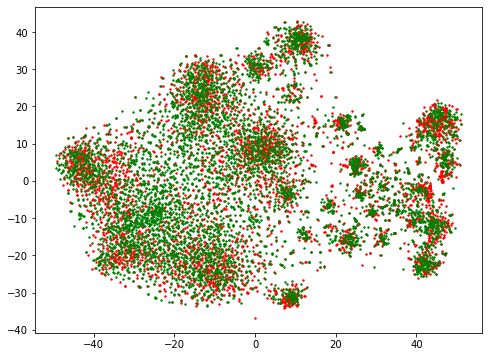

In [99]:
plt.figure(figsize=[8,6])
plt.scatter(x[:4393,0],x[:4393,1],s=2,color='r')
plt.scatter(x[4393:,0],x[4393:,1],s=2,color='g')

In [56]:
synID_mapping_df.loc[synID_mapping_df['domain']=='ConsigneePanjivaID']

,domain,entity_id,syn_id
0,ConsigneePanjivaID,0,0
1,ConsigneePanjivaID,1,1
2,ConsigneePanjivaID,2,2
3,ConsigneePanjivaID,3,3
4,ConsigneePanjivaID,4,4
...,...,...,...
4388,ConsigneePanjivaID,4388,4388
4389,ConsigneePanjivaID,4389,4389
4390,ConsigneePanjivaID,4390,4390
4391,ConsigneePanjivaID,4391,4391


In [59]:
tsne1 = TSNE(n_components=2, perplexity=30.0,verbose=1)
x1 = tsne1.fit_transform(input_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10012 samples in 0.118s...
[t-SNE] Computed neighbors for 10012 samples in 21.905s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10012
[t-SNE] Computed conditional probabilities for sample 2000 / 10012
[t-SNE] Computed conditional probabilities for sample 3000 / 10012
[t-SNE] Computed conditional probabilities for sample 4000 / 10012
[t-SNE] Computed conditional probabilities for sample 5000 / 10012
[t-SNE] Computed conditional probabilities for sample 6000 / 10012
[t-SNE] Computed conditional probabilities for sample 7000 / 10012
[t-SNE] Computed conditional probabilities for sample 8000 / 10012
[t-SNE] Computed conditional probabilities for sample 9000 / 10012
[t-SNE] Computed conditional probabilities for sample 10000 / 10012
[t-SNE] Computed conditional probabilities for sample 10012 / 10012
[t-SNE] Mean sigma: 2.855935
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.457588
[t-SNE] K

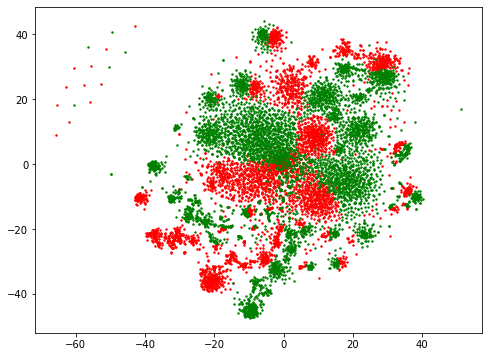

In [61]:
plt.figure(figsize=[8,6])
plt.scatter(x1[:4393,0],x1[:4393,1],s=2,color='r')
plt.scatter(x1[4393:,0],x1[4393:,1],s=2,color='g')

In [82]:
# Try to see if GNN neigborhood distance scores match 
pos_nbr_dict[10005]

[4377, 859]

In [85]:
from scipy.spatial.distance import cosine

cosine(data[10005],data[7500])


1.0476041994988918

In [86]:
data[10005]

array([ 0.00203777, -0.00203975, -0.00203936,  0.00203979,  0.00101335,
       -0.00203985,  0.0020396 ,  0.00033069, -0.00200448, -0.00156316,
       -0.00203939, -0.00203705,  0.00199384,  0.00190711,  0.00195072,
       -0.00199896,  0.00026803,  0.00185931, -0.00203721, -0.00203354,
       -0.00172684, -0.0004197 ,  0.0020314 , -0.00202711, -0.00104781,
        0.00203384,  0.00050772,  0.00203784,  0.00049245,  0.00188723,
       -0.00203984, -0.00202091], dtype=float32)